In [64]:
from __future__ import print_function
%matplotlib inline
import cv2
import os
from skimage import io, transform
import numpy as np
from tqdm import tqdm
import random

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import torch
from torchvision import transforms, datasets, utils as vutils
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

plt.rcParams['figure.figsize'] = [10, 5]

# %load_ext autoreload
# %autoreload 2

In [134]:
## Params 

# Image path
training_data_full = "data/training/full"
training_data_empty = "data/training/empty"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 6

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0001

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

epochs = 200


# Train Test and Validate partitions
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

In [135]:
class WormClassDataset(Dataset):
    """ Full and emty are the paths to the data contianing
    the list of images. 0 = empty, 1 = full.
    Transform is the pytorch transformations to apply
    """
    def __init__(self, full_path, empty_path, transform=None):
        self.full_path = full_path
        self.full = os.listdir(full_path)
        self.empty_path = empty_path
        self.empty = os.listdir(empty_path)
        
        self.balace_data()
        self.data = self.full + self.empty
        self.remove_ds()
        
        self.transform = transform
        
    def balace_data(self):
        """Takes images form the two classes and curates the data so it's 50/50"""
        d = [self.full, self.empty]
        small = np.argmin([len(d[0]), len(d[1])])
        
        new_idxs = random.sample(range(0, len(d[not small])), len(d[small])) 
        new = [d[not small][i] for i in new_idxs]
        print(len(new))
                                       
        if not small:
            self.empty = new
        elif small:
            self.full = new
            
    def remove_ds(self):
        if '.DS_Store' in self.data:
            self.data.remove('.DS_Store')
            
    def __len__(self):
        data_count = len(self.data)
        return data_count

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        if idx < len(self.full):
            _class = 1
            img_name = os.path.join(self.full_path, self.data[idx])  
        else:
            _class = 0
            img_name = os.path.join(self.empty_path, self.data[idx])  

        image = io.imread(img_name)
        image = cv2.normalize(image, image, 0, 255, cv2.NORM_MINMAX)

        sample = image

        if self.transform:
            sample = self.transform(sample)

        return {'image': sample, 'class': _class}

test = WormClassDataset(training_data_full, training_data_empty)
b = test.__getitem__(0)
print(b['class'])

785
1


## Transform the data

In [136]:
# Resize, convert to grayscale, convert to tensor, normalize, and rotate.
data_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
#         transforms.Normalize((0.5), (0.5))
    ])

worm_class_dataset = WormClassDataset(training_data_full, training_data_empty, transform=data_transform)


# Init gpu device if present.
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

785
cuda:0


0


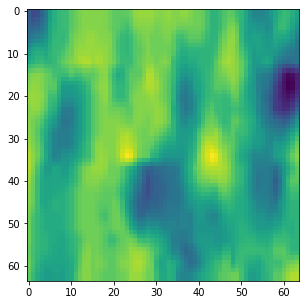

In [137]:
# Show sample image from the dataset.

rand_saple = worm_class_dataset.__getitem__(np.random.randint(0, len(worm_class_dataset)))
plt.imshow(torch.reshape(rand_saple['image'], (64, 64, 1)))
print(rand_saple['class'])




## Create the actual dataloader
### Also will split data into train test and validate
___Will shuffle the data, and batch it___

In [138]:
train_count = round(len(worm_class_dataset) * train_ratio)
val_test_count = len(worm_class_dataset) - train_count
val_count = round(len(worm_class_dataset) * val_ratio)
test_count = round(len(worm_class_dataset) * test_ratio)
# Training and val + test dataset.

# The datasets needed for training
seed = torch.manual_seed(42)
seed2 = torch.manual_seed(55)

train_set, val_test_set = torch.utils.data.random_split(worm_class_dataset, [train_count, val_test_count], generator=seed)
val_set, test_set = torch.utils.data.random_split(val_test_set, [val_count, test_count], generator=seed2)

# Training DATA-LOADER
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_set, batch_size=1, shuffle=True, num_workers=0)


## Begin designing one of the model options
___Will try a few things:____

In [139]:
class WormClassifier(nn.Module):
    
    def __init__(self, dim):
        super(WormClassifier, self).__init__()
        self.conv1_1 = nn.Conv2d(1, 12, 5, 1, padding=2)
        self.conv1_2 = nn.Conv2d(12, 12, 5, 1, padding=2)
        
        self.conv2_1 = nn.Conv2d(12, 24, 5, 1, padding=2)
        self.conv2_2 = nn.Conv2d(24, 24, 5, 1, padding=2)
        
        self.conv3_1 = nn.Conv2d(24, 36, 5, 1, padding=2)
        self.conv3_2 = nn.Conv2d(36, 36, 5, 1, padding=2)
 
        self.conv4_1 = nn.Conv2d(36, 48, 5, 1, padding=2)
        self.conv4_2 = nn.Conv2d(48, 48, 5, 1, padding=2)
        # self.conv4_2 = nn.Conv2d(48, 48, 5, 1, padding=2)
        
        
        # self.conv5_1 = nn.Conv2d(48, 60, 5, 1, padding=2)
        # self.conv5_2 = nn.Conv2d(60, 60, 5, 1, padding=2)
        
        self.fc1 = nn.Linear(768, 256)
        self.fc2 = nn.Linear(256, 1)
        # self.fc3 = nn.Linear(90, 1)
        # self.fc3 = nn.Linear(2048, 1)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = F.max_pool2d(x, 2)
            
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.max_pool2d(x, 2)
        
        # x = F.relu(self.conv5_1(x))
        # x = F.relu(self.conv5_2(x))
        
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc2(x))
        
        return x
    
    
    
class WormClassifier2(nn.Module):

    def __init__(self, dim):
        super(WormClassifier2, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, 5, 1, 2)
        self.conv2 = nn.Conv2d(12, 24, 5, 1, 2)
        self.conv3 = nn.Conv2d(24, 36, 5, 1, 2)

        self.fc1 = nn.Linear(576, 144)
        self.fc2 = nn.Linear(144, 1)
    #         self.conv5_1 = nn.Conv2d(512, 512, 5, 1 padding=2)
    #         self.conv5_2 = nn.Conv2d(512, 512, 5, 1 padding=2)

        # self.fc1 = nn.Linear(512 * 4 * 4, 256 * 4 * 4)
        # self.fc2 = nn.Linear(4096, 2048)
        # self.fc3 = nn.Linear(2048, 1)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 4)
        
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))


        return x

    
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [140]:
# Define the model

model = WormClassifier(image_size).to(device)
# model.apply(weights_init)  # Random starting weights.
# sample = train_set[3]["image"].unsqueeze(1).to(device)
# model(sample).shape

print(model)

# model2 = WormClassifier2(image_size).to(device)
# model2(sample).shape

WormClassifier(
  (conv1_1): Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1_2): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2_1): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2_2): Conv2d(24, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3_1): Conv2d(24, 36, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3_2): Conv2d(36, 36, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4_1): Conv2d(36, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4_2): Conv2d(48, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)


Choose loss function and setup optimizer

In [141]:
# Initialize BCELoss function
criterion = nn.BCELoss()

empty_labe = 0
full_label = 1

optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999))  # betas=(beta1, 0.999)
# optimizer = optim.Adam(model.parameters(), lr=0.0001)  # betas=(beta1, 0.999)


# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [142]:
def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_dataloader:
            inputs, labels = data["image"], data["class"]
            inputs = inputs.to(device)
            labels = labels.unsqueeze(1).to(torch.float32)
            labels = labels.to(device)

            outputs = model(inputs)
            for label, prediction in zip(labels, outputs):
                prediction = prediction.to(torch.int)
                if label == prediction:
                    correct += 1
                else:
                    pass

                total += 1

            # inputs, labels = data["image"], data["class"]
    
    return(correct / total)


In [143]:
# Training Loop

losses = []
iters = 0
tests = []

best = 0


for epoch in range(0, epochs):
    
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data["image"], data["class"]
        labe_size = len(labels)
        labels = labels.unsqueeze(1).to(torch.float32)
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # Pass model, backprop, optimize.
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print Stats

        running_loss += loss.item()
        if i % 40 == 39:
            # print(outputs, labels)
            losses.append(running_loss / 40)

            print(f'[{epoch + 1}, {i}] loss: {running_loss / 40}')
            running_loss = 0.0
    
    # Run test at end of every epoch
    test_ac = test()
    if test_ac > best:
        torch.save(model.state_dict(), "weights/best-model.pt")
        best = test_ac
    tests.append(test_ac)

    # Print stats
    print(f"[{epoch + 1} / {epoch}] accuracy = {test_ac} loss = {loss.item()}")    
    
    
            
        
        
        

[1, 39] loss: 0.6938401490449906
[1, 79] loss: 0.6936705425381661
[1, 119] loss: 0.695087842643261
[1, 159] loss: 0.6760250732302666
[1, 199] loss: 0.540933109074831
[1 / 0] accuracy = 0.47770700636942676 loss = 0.35528460144996643
[2, 39] loss: 0.374950550775975
[2, 79] loss: 0.47139490116387606
[2, 119] loss: 0.4221565306186676
[2, 159] loss: 0.4718128629028797
[2, 199] loss: 0.35840638894587756
[2 / 1] accuracy = 0.47770700636942676 loss = 0.05280802398920059
[3, 39] loss: 0.30023958180099725
[3, 79] loss: 0.4316368283703923
[3, 119] loss: 0.38826515986584126
[3, 159] loss: 0.4545905042439699
[3, 199] loss: 0.3444628072436899
[3 / 2] accuracy = 0.47770700636942676 loss = 0.042233504354953766
[4, 39] loss: 0.36035692766308786
[4, 79] loss: 0.33845394682139157
[4, 119] loss: 0.32660546284168956
[4, 159] loss: 0.3554068643599749
[4, 199] loss: 0.33425542870536445
[4 / 3] accuracy = 0.47770700636942676 loss = 0.002344557549804449
[5, 39] loss: 0.2830429754219949
[5, 79] loss: 0.30953686

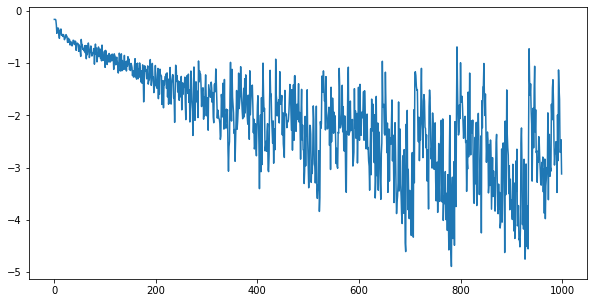

In [144]:
log_losses = [np.log10(i) for i in losses]
plt.plot(log_losses)

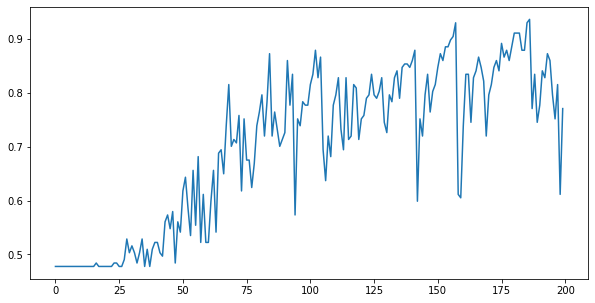

In [146]:
plt.plot(tests)

## Test the model on the "Test" data-set

In [147]:
# high_epoch = np.argmax(tests)
# print(f"best epoch = {tests[high_epoch]}")

# Load the best model
best_model = WormClassifier(image_size)
best_model.load_state_dict(torch.load("weights/best-model.pt"))



<All keys matched successfully>

In [151]:

def validate():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_set:
            img, labels = data["image"], data["class"]
            img = img.unsqueeze(1)
            # labels = labels.unsqueeze(1).to(torch.float32)
            # labels = labels.to(device)

            output = best_model(img)
            output = output.squeeze(1)[0].to(int)
            # print(output, labels)
            if output == labels:
                
                correct += 1
            else:
                pass
                
            total += 1
    
    return(correct / total)

            
#             for label, prediction in zip(labels, outputs):
#                 prediction = prediction.to(torch.int)
#                 if label == prediction:
#                     correct += 1
#                 else:
#                     pass

#                 total += 1

#             # inputs, labels = data["image"], data["class"]
    
#     return(correct / total)


sample = val_set[23]
img = sample["image"]
label = sample["class"]

img = img.unsqueeze(1)
pred = best_model(img)
# img.shape
acc = validate()
print(acc)

print(int(pred.squeeze(1)[0]) == 1)
print(pred.squeeze(1)[0])

0.9426751592356688
False
tensor(1.0887e-13, grad_fn=<SelectBackward>)


In [56]:
devicetorch.cuda.is_available()

NameError: name 'devicetorch' is not defined

In [35]:
a = [1,2,3]
for v in tqdm(a):
    print(v)
    pass

100%|██████████| 3/3 [00:00<00:00, 26105.63it/s]

1
2
3
